In [1]:
#export
from exp.nb_05b import *
import torch 
torch.set_num_threads(2)

# ConvNet

In [2]:
x_train,y_train,x_valid,y_valid = get_data()

In [4]:
x_train.mean(),x_train.std()

(tensor(9.3006e-09), tensor(1.))

In [5]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [6]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [20]:
#export
class Lambda(nn.Module):
    def __init__(self,func):
        super().__init__()
        self.func= func
    def forward(self,x): return self.func(x)

In [21]:
#export
def flatten(x): return x.view(x.shape[0],-1)
def mnist_resize(x): return x.view(-1,1,28,28)

In [22]:
x_train.shape

torch.Size([60000, 784])

In [23]:
mnist_resize(x_train).shape

torch.Size([60000, 1, 28, 28])

In [24]:
def get_cnn(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2),nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
        
    )

In [25]:
model = get_cnn(data)

In [26]:
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

In [27]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [28]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [29]:
%time run.fit(1, learn)

train: [1.423844921875, tensor(0.5278)]
valid: [0.435185693359375, tensor(0.8639)]
CPU times: user 6.2 s, sys: 99.8 ms, total: 6.3 s
Wall time: 3.26 s


## CUDA

In [30]:
# Somewhat more flexible way
device = torch.device('cuda',0)

In [31]:
class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

In [32]:
torch.cuda.set_device(device)

In [33]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [34]:
cbfs.append(CudaCallback)

In [44]:
model = get_cnn(data)

In [45]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [46]:
%time run.fit(5, learn)

train: [2.254160677083333, tensor(0.2004, device='cuda:0')]
valid: [1.57027783203125, tensor(0.4697, device='cuda:0')]
train: [0.702886328125, tensor(0.7791, device='cuda:0')]
valid: [0.2372393798828125, tensor(0.9278, device='cuda:0')]
train: [0.19895266927083333, tensor(0.9399, device='cuda:0')]
valid: [0.18679989013671874, tensor(0.9458, device='cuda:0')]
train: [0.1295716552734375, tensor(0.9608, device='cuda:0')]
valid: [0.1464746337890625, tensor(0.9509, device='cuda:0')]
train: [0.10197193196614583, tensor(0.9693, device='cuda:0')]
valid: [0.07995880737304688, tensor(0.9750, device='cuda:0')]
CPU times: user 7.17 s, sys: 111 ms, total: 7.28 s
Wall time: 7.22 s


# Refactor Model

In [47]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [48]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [49]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [51]:
nfs = [8,16,32,32]

In [52]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [53]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [54]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [55]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [56]:
run.fit(3, learn)

train: [2.110833203125, tensor(0.2378, device='cuda:0')]
valid: [1.20673134765625, tensor(0.5823, device='cuda:0')]
train: [0.45249723307291667, tensor(0.8628, device='cuda:0')]
valid: [0.2761402099609375, tensor(0.9142, device='cuda:0')]
train: [0.16187794596354166, tensor(0.9515, device='cuda:0')]
valid: [0.128790625, tensor(0.9589, device='cuda:0')]


# Hooks 

In [57]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [62]:
cbfs

[exp.nb_05b.Recorder,
 functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7f1774470048>),
 __main__.CudaCallback,
 functools.partial(<class '__main__.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x7f169b937620>)]

In [67]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [68]:
run.fit(2, learn)

train: [2.2025299479166667, tensor(0.2096, device='cuda:0')]
valid: [1.6005787109375, tensor(0.4601, device='cuda:0')]
train: [0.7381723307291667, tensor(0.7535, device='cuda:0')]
valid: [0.2984437744140625, tensor(0.9041, device='cuda:0')]


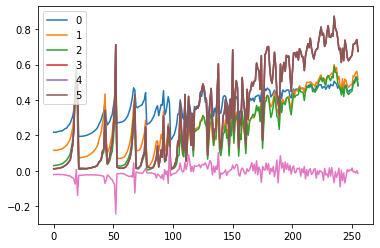

In [69]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

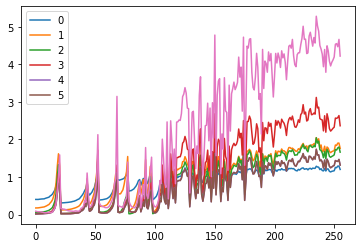

In [70]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

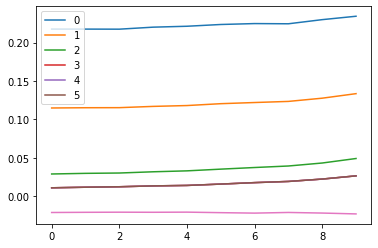

In [71]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

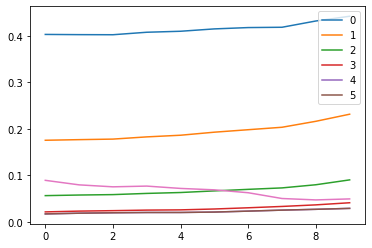

In [72]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

# PyTorch Hooks 

In [74]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [75]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [76]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [77]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [78]:
run.fit(1, learn)

train: [1.94874296875, tensor(0.3097, device='cuda:0')]
valid: [0.70940283203125, tensor(0.7653, device='cuda:0')]


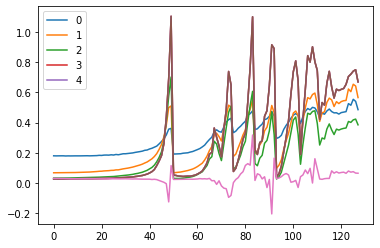

In [79]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

# Hook Class 

In [80]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [82]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [83]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [84]:
run.fit(1, learn)

train: [1.8238391927083333, tensor(0.3732, device='cuda:0')]
valid: [0.689219873046875, tensor(0.7865, device='cuda:0')]


In [91]:
hooks[0].hook

In [ ]:
hooks[0].hook

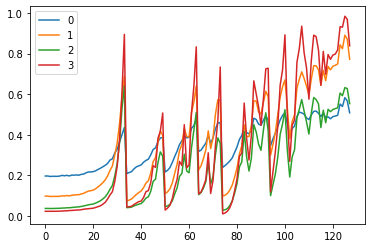

In [85]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

# Hooks Class 

In [92]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [93]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [94]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [95]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [96]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f1690ae6ef0>, <__main__.Hook object at 0x7f1690ae6668>, <__main__.Hook object at 0x7f1690ae6a20>, <__main__.Hook object at 0x7f1690d2b1d0>, <__main__.Hook object at 0x7f1690d2b278>, <__main__.Hook object at 0x7f1690d2b0f0>, <__main__.Hook object at 0x7f1690d2bbe0>]